<br>

## 1. Preparing dataset (2번부터 실습 진행)

## Data info

- **PassengerId** : Unique ID of passenger
- **Survived** : 0 = No, 1 = Yes
- **pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- **sibsp** : # of siblings & spouses aboard the Titanic
- **parch** : # of parents / children aboard the Titanic
- **ticket** : Ticket number
- **cabin** : Cabin number
- **embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [37]:
# data_df = pd.read_csv('titanic.csv')
# data_df.head(3)
# y_data = data_df[['Survived']]
# y_data.head(3)
# del data_df['Survived']
# x_data = data_df.copy()
# x_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
# x_data.info()
# 기본적인 결측치 채우는 방법
# #fillna(0) -> 0으로 빠진 값 채워넣음
# mean_age = x_data['Age'].median(skipna=True) #null값 제외한 데이터 평균값
# x_data['Age'] = x_data['Age'].fillna(mean_age) # or .fillna(int/float/str 값)

<br>

## 2. Feature engineering & Feature selection

#### 시도해볼 수 있는 전략들

- 불필요한 열이나 예측에 방해가 되는 열은 아예 지우기 (ex. PassengerId)
- 결측치 채우기 
- Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 (ex. Male/Female -> 0/1)
- 실수 범위를 구간 범위로 바꿔주기 
- 필요한 경우 기존 열을 바탕으로 새로운 열을 계산해 추가하기

<br>

## 비지도학습- 클러스터링 : K-means
## 지도학습 - 분류 : Kernel SVM

In [ ]:
#k-means(비지도학습 - 클러스터링) : 데이터별 클러스터링이다.(엘보우,실루엣) 
#실루엣 최대값 0.767 #엘보우 클러스터 적합 개수 = 2 -> 클러스터링하기에 적합
#SVM(지도학습 - 분류) : 전체 데이터의 값에 대해 Survive열 예측

In [1]:
#주어진 Library
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#k-means Library
from mpl_toolkits.mplot3d import Axes3D

from sklearn import cluster
from sklearn import datasets
from sklearn import metrics

#k-means silhouette 기법 Library
from sklearn.metrics import silhouette_samples
from matplotlib import cm
from sklearn.metrics import silhouette_score


#SVM
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
#성별 데이터 숫자 변환 함수
def gd_to_num(data):
    if data == 'male':
        return 1
    else:
        return 2
#출발지 데이터 숫자 변환 함수    
def em_to_num(data):
    if data == 'C':
        return 1
    elif data == 'Q':
        return 2
    else:
        return 3


<br>

## K-means

In [3]:
#k-means 
#데이터 준비
#x_data만 준비하면 됨 :  # 0: Survived, 1: Age, 2: New_Fare
data_df = pd.read_csv('titanic.csv')
data_df.head(3)
x_data = data_df.copy()

#Feature engineering & Feature selection(데이터 열 고르기)
split_name = []
Fare_list = []
room_floor = []

#연관성 없는 열 제거
del x_data['PassengerId'] 
del x_data['Ticket']
del x_data['Name'] 
#이름의 경우 공통점인 (Mr, Mrs, Miss.....) = 성별과 관련있음
#성별 열과 겹쳐 이름 열 삭제

x_data['gender'] = x_data['Sex'].apply(gd_to_num) #기존 성별 열 -> 'Gender'열로 새로 만듬
del x_data['Sex'] #기존 성별 열 삭제

x_data['Age'] = x_data['Age'].fillna(0) #Age 열 결측치 채우기

#해당 Fare 열을 for문 이용하여 자릿수 2자리로 만들고 'New_Fare'열로 새로 만듬, 기존 Fare열 삭제
Fare = x_data['Fare']

for fare in Fare:
    Fare_list.append(round(fare,2))
x_data['New_Fare'] = Fare_list

del x_data['Fare']

#해당 'Embarked'열을 함수를 이용하여 숫자로 바꾸고 새로운 열로 만듬
x_data['New_Embarked'] = x_data['Embarked'].apply(em_to_num)
del x_data['Embarked']

#해당 'Cabin'열을 가장 앞의 알파벳만 남기고 제거 및 결측치 Null값으로 채움(결측치의 경우 N으로 뽑혀져나옴)
x_data['Cabin'] = x_data['Cabin'].fillna('Null')
x_data['Cabin'] = x_data['Cabin'].str.replace(pat=r'[^A-Z]', repl=r' ', regex=True)

room_num = x_data['Cabin']

for room in room_num: 
    room = room.split(' ')
    room_floor.append(room[0])

x_data['New Cabin'] = room_floor

#기존 열 삭제 후 새로운 열 'New_Cabin' 열에 알파벳에 대해 숫자로 대체
x_data['New_Cabin'] = x_data['New Cabin'].replace(['A','B','C','D','E','F','G','T','N'], [1,2,3,4,5,6,7,8,9])

#쓸 데이터 열만 남기고 삭제
del x_data['Cabin']
del x_data['New Cabin']
del x_data['Pclass']
del x_data['SibSp']
del x_data['Parch']
del x_data['gender']
del x_data['New_Embarked']
del x_data['New_Cabin']

#해당 열 데이터프레임 복사
new_x_data = x_data.copy()

new_x_data.head(30)

,Survived,Age,New_Fare
0,0,22.0,7.25
1,1,38.0,71.28
2,1,26.0,7.92
3,1,35.0,53.10
4,0,35.0,8.05
5,0,0.0,8.46
6,0,54.0,51.86
7,0,2.0,21.07
8,1,27.0,11.13
9,1,14.0,30.07


In [14]:
#이 배에 승선한 사람 전체에 대해 클러스터 중심 값 계산(k-means)
#0: Survived 2:Age 6:New_Fare 중 이 세개의 열으로 파악
#new_x_data에 대해 numpy.array로 만듬
use_x_data = np.array(new_x_data)
X = use_x_data

<br>

## Kernel SVM

In [13]:
#커널 SVM
#데이터 준비
#x_data : Survived 열을 제외한 나머지 열
#y_data : Survived 열
#나머지는 위와 동일하게 세팅
data_df = pd.read_csv('titanic.csv')
data_df.head(3)
y_data = data_df[['Survived']]
y_data.head(3)
del data_df['Survived']
x_data = data_df.copy()
x_data.head(3)

#열 고르기
split_name = []
Fare_list = []
room_floor = []

#연관성 없는 열 제거
del x_data['PassengerId']
del x_data['Ticket']
del x_data['Name'] 

x_data['gender'] = x_data['Sex'].apply(gd_to_num)
del x_data['Sex']

x_data['Age'] = x_data['Age'].fillna(0)


Fare = x_data['Fare']

for fare in Fare:
    Fare_list.append(round(fare,2))

x_data['New_Fare'] = Fare_list
del x_data['Fare']

x_data['New_Embarked'] = x_data['Embarked'].apply(em_to_num)
del x_data['Embarked']

x_data['Cabin'] = x_data['Cabin'].fillna('Null')
x_data['Cabin'] = x_data['Cabin'].str.replace(pat=r'[^A-Z]', repl=r' ', regex=True)

room_num = x_data['Cabin']

for room in room_num: 
    room = room.split(' ')
    room_floor.append(room[0])

x_data['New Cabin'] = room_floor

x_data['New_Cabin'] = x_data['New Cabin'].replace(['A','B','C','D','E','F','G','T','N'], [1,2,3,4,5,6,7,8,9])

del x_data['Cabin']
del x_data['New Cabin']

new_x_data = x_data.copy()

new_x_data.head()

,Pclass,Age,SibSp,Parch,gender,New_Fare,New_Embarked,New_Cabin
0,3,22.0,1,0,1,7.25,3,9
1,1,38.0,1,0,2,71.28,1,3
2,3,26.0,0,0,2,7.92,3,9
3,1,35.0,1,0,2,53.10,3,3
4,3,35.0,0,0,1,8.05,3,9


<br>

## Kernel SVM Feature Scaling(Min-Max)

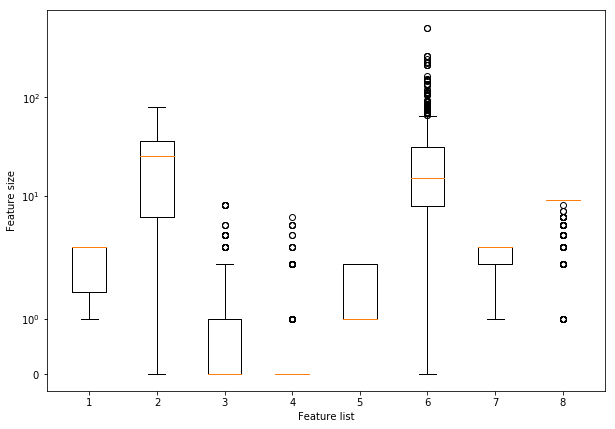

,0,1,2,3,4,5,6,7
count,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000
mean,0.643660,0.301314,0.066413,0.065543,0.345104,0.063354,0.781701,0.829254
std,0.420328,0.220012,0.145361,0.138681,0.475784,0.094193,0.385241,0.314466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.075000,0.000000,0.000000,0.000000,0.015459,0.500000,1.000000
50%,1.000000,0.312500,0.000000,0.000000,0.000000,0.029278,1.000000,1.000000
75%,1.000000,0.450000,0.125000,0.000000,1.000000,0.061269,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
#커널 SVM Feature Scaling 처리 (전처리)
#X_train 데이터 전처리

#바로 5번으로 내려가기
# df = pd.DataFrame(X_train)
# df.head()

#수염상자로 해당 X_train Feature Scale 알아보기
plt.figure(figsize=(10,7))
plt.boxplot(X_train, manage_xticks=False)

plt.yscale("symlog")
plt.xlabel("Feature list")
plt.ylabel("Feature size")
plt.show()

#Feature Scale을 위해 MinMax알고리즘 적용
sc = MinMaxScaler()
sc.fit(X_train)

X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

df = pd.DataFrame(X_train_scaled)
df.describe()

<br>

## Kernel SVM Feature Scaling(Standardization Mean)

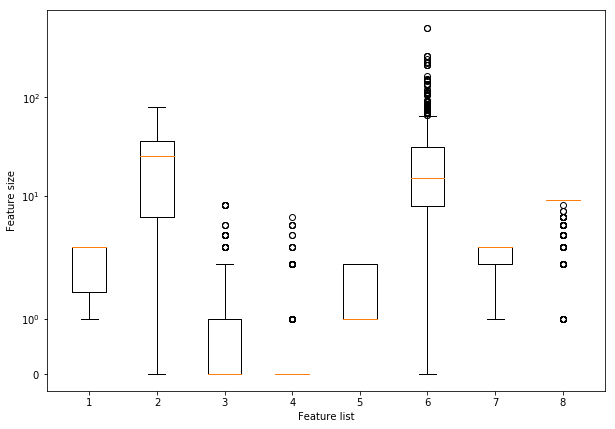

,0,1,2,3,4,5,6,7
count,6.230000e+02,6.230000e+02,6.230000e+02,6.230000e+02,6.230000e+02,6.230000e+02,6.230000e+02,6.230000e+02
mean,1.630584e-17,2.922577e-17,1.013992e-16,-3.054450e-16,1.725034e-16,7.446335e-16,1.211800e-16,9.551839e-17
std,1.000804e+00,1.000804e+00,1.000804e+00,1.000804e+00,1.000804e+00,1.000804e+00,1.000804e+00,1.000804e+00
min,-1.532556e+00,-1.370636e+00,-4.572460e-01,-4.729977e-01,-7.259206e-01,-6.731401e-01,-2.030754e+00,-2.639144e+00
25%,-9.373053e-01,-1.029472e+00,-4.572460e-01,-4.729977e-01,-7.259206e-01,-5.088896e-01,-7.318220e-01,5.434094e-01
50%,8.484476e-01,5.088262e-02,-4.572460e-01,-4.729977e-01,-7.259206e-01,-3.620597e-01,5.671099e-01,5.434094e-01
75%,8.484476e-01,6.763509e-01,4.033711e-01,-4.729977e-01,1.377561e+00,-2.215246e-02,5.671099e-01,5.434094e-01
max,8.484476e-01,3.178224e+00,6.427691e+00,6.743595e+00,1.377561e+00,9.951916e+00,5.671099e-01,5.434094e-01


In [23]:
plt.figure(figsize=(10,7))
plt.boxplot(X_train, manage_xticks=False)

plt.yscale("symlog")
plt.xlabel("Feature list")
plt.ylabel("Feature size")
plt.show()

sc = StandardScaler()
sc.fit(X_train)

X_train_scaled2 = sc.transform(X_train)
X_test_scaled2 = sc.transform(X_test)

df = pd.DataFrame(X_train_scaled2)
df.describe()

<br>

## 3. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)

<br>

## K-means

In [6]:
#비어있는 모델 객체 만들기 + 모델 학습시키기
#k-means
#k=2로 정함
estimators = [('k=2', cluster.KMeans(n_clusters=2, random_state = 0).fit(X)),
              ('k=3', cluster.KMeans(n_clusters=3, random_state = 0).fit(X)),
              ('k=2(r)', cluster.KMeans(n_clusters=2, n_init=1, init='random', random_state = 0).fit(X))] # random init

print(estimators[0]), print()
print(estimators[1]), print()
print(estimators[2])

('k=2', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0))

('k=3', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0))

('k=2(r)', KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=2, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0))


<br>

## Kernel SVM

In [15]:
#커널 SVM 전체 데이터에 대한 Survived 열
use_x_data = np.array(new_x_data)
use_y_target = np.array(y_data)

X_train, X_test, y_train, y_test = train_test_split(use_x_data, use_y_target, 
                                                    test_size = 0.3, train_size = 0.7, random_state=0)


<br>

## 4. Create model instance variable (동시에 여러 모델을 다른 이름으로 만들 수 있습니다.)

<br>

## elbow & silhouette(K-means)

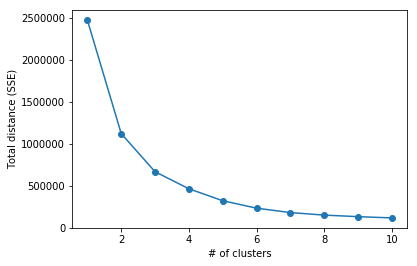

In [7]:
#엘보우 기법(k-means)
def elbow(X):
    total_distance = []
    
    for i in range(1, 11):
        model = cluster.KMeans(n_clusters=i, random_state=0)
        model.fit(X) #트레이닝(피팅) 시킴
        
        # inertia : Sum of squared distances of samples to their closest cluster center.
        total_distance.append(model.inertia_) 
        # inertia -> 클러스터링 끝나고 데이터 샘플에 대해 
        #가장 가까운 하나의 숫자를 줌 , 작아지면 작아질수록 클러스터링 잘된거임
        
        #하나의 전제조건(엘보우,실루엣) : 클러스터링 잘 됬을때의 기준 같은 클러스터끼리는 똘똘뭉침, 다른 클러스터끼리는 최대한 멀리
    plt.plot(range(1, 11), total_distance, marker='o')
    plt.xlabel('# of clusters')
    plt.ylabel('Total distance (SSE)')
    plt.show()

elbow(X) #elbow : 2~3일때 꺾임

The average silhouette value is 0.77 (near 0.7 or 0.7+ : desirable)


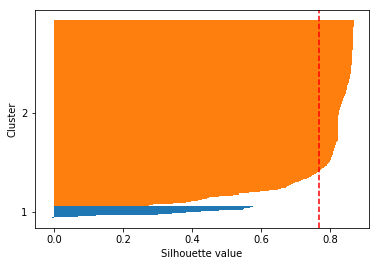

In [8]:
#실루엣 기법(k-means)
#실루엣 값 : 2일때 가장 높음 : 0.77
def plotSilhouette(X, y_fitted):
    cluster_labels = np.unique(y_fitted)
    n_clusters = cluster_labels.shape[0] # ex) (3,) -> 3
    silhouette_vals = silhouette_samples(X, y_fitted, metric='euclidean') # y_fitted 클러스터 라벨을 기준으로 한 X 데이터 각각이 가지는 실루엣 계수를 계산
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    
    for index, label in enumerate(cluster_labels):
        cluster_silhouette_vals = silhouette_vals[y_fitted == label] # 각 라벨(center=3이면 0,1,2)에 해당하는 예측 데이터들의 실루엣 계수
        cluster_silhouette_vals.sort()
        
        # 라벨 순서대로 클러스터로 할당된 데이터 수만큼 y_ax_upper 에 더하여 y축 방향으로 쌓음
        y_ax_upper += len(cluster_silhouette_vals) 
        
        plt.barh(range(y_ax_lower, y_ax_upper), cluster_silhouette_vals, height=1.0) # barh(y, data), edge_color=None
        yticks.append((y_ax_lower + y_ax_upper) / 2) # 그래프에서 y축 위에 클러스터 번호 라벨링 적용
        
        # 라벨 순서대로 클러스터로 할당된 데이터 수만큼 y_ax_lower 에 더하여 y축 방향으로 쌓음
        y_ax_lower += len(cluster_silhouette_vals) 
        
    silhouette_avg = np.mean(silhouette_vals) # 전체 데이터에 대한 실루엣 계수의 평균
    plt.axvline(silhouette_avg, color='red', linestyle='--') # 전체 데이터에 대한 실루엣 계수의 평균을 수직선으로 표시
    print('The average silhouette value is', round(silhouette_avg, 2), '(near 0.7 or 0.7+ : desirable)')
    
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette value')
    plt.show()

    
#모델 만들기    
model = cluster.KMeans(n_clusters=2)# Change the number of clusters
#fit하고 클러스터 번호 알아냄
y_fitted = model.fit_predict(X)
#그걸주고 원본데이터(X)
plotSilhouette(X, y_fitted)

In [9]:
#실루엣 지수 나타냄 -> 0.767
model = cluster.KMeans(n_clusters=2)
y_fitted = model.fit_predict(X)

silhouette_avg = silhouette_score(X, y_fitted)
print("The average of silhouette coefficients is :", silhouette_avg)

The average of silhouette coefficients is : 0.7677147585520057


<br>

## Kernel SVM(모두 동일 사용 가능)

In [24]:
#커널 SVM만들고 학습
svc = SVC()

<br>

## 5. Train the model

<br>

## Kernel SVM

In [17]:
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

<br>

## Kernel SVM Feature Scaling 후(Min-Max)

In [21]:
#커널 SVM
#Feature Scaling 이후 학습
svc.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

<br>

## Kernel SVM Feature Scaling 후(Standardization Mean)

In [25]:
svc.fit(X_train_scaled2, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

<br>

## 6. Predict on test data & Check the result with metrics (모델 간 비교가 가능합니다.)

<br>

## K-means 클러스터 값 및 중심값

In [10]:
#클러스터로 나눈 클래스 표기 및 중심값 표시
for name,est in estimators:
    select_km = est
    print("Clusters : ", select_km.labels_), print()
    print("Cluster centroids: ", select_km.cluster_centers_), print()

Clusters :  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

<br>

## K-means 시각화(생존여부,나이,운임요금)

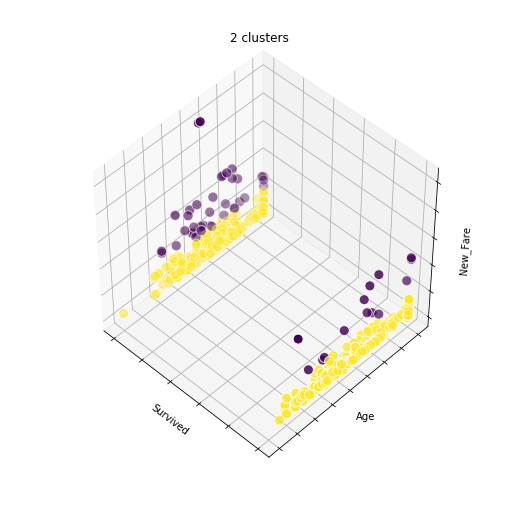

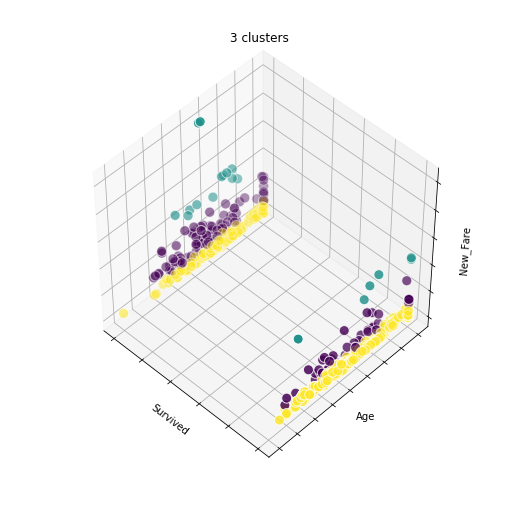

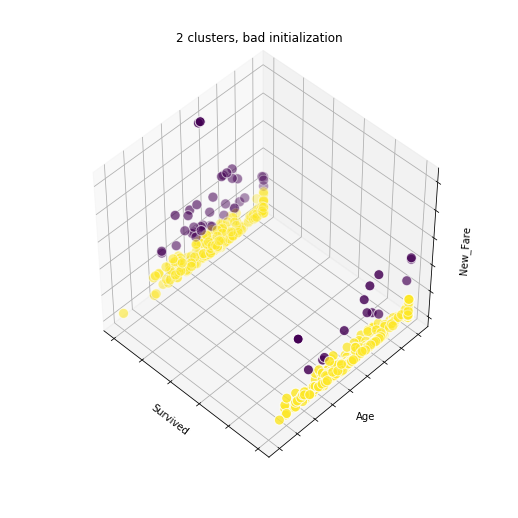

In [11]:
#k-means
#도화지 번호 #도화지를 병렬로 만듬
fignum = 1

titles = ['2 clusters', '3 clusters', '2 clusters, bad initialization']


# ('k=8', cluster.KMeans(n_clusters=8)
for name, est in estimators: # estimators : ('k=8', cluster.KMeans(n_clusters=8))
    fig = plt.figure(fignum, figsize=(7, 7)) #fignum : 도화지번호 아래에서 증가
    #3D 도화지로 바꿔줌 elev 고도, azim 방위각
    #plotly, 시각화라이브러리 사용
    ax = Axes3D(fig, elev=48, azim=134) # Set the elevation and azimuth of the axes. (축의 고도와 방위각)
    
    est.fit(X)
    
    labels = est.labels_

    # X = new_x_data
    # 0: Survived, 1: Age, 2: New_Fare
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels.astype(np.float), edgecolor='w', s=100)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Survived')
    ax.set_ylabel('Age')
    ax.set_zlabel('New_Fare')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12 # 값이 커지면 전체 plot 이 작아짐
    fignum = fignum + 1

plt.show()

<br>

## Kernel SVM

In [18]:
#Train> Test 보다 현저하게 크므로 오버피팅 발생
#Train : 0.907 , Test : 0.679
#해당 열 feature Scaling 필요 -> 데이터 열 고르기로 돌아감
print("Accuracy on Training set: {:.3f}".format(svc.score(X_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(svc.score(X_test, y_test)))

Accuracy on Training set: 0.907
Accuracy on Test set: 0.679


<br>

## Kernel SVM Feature Scaling 후(Min-Max)

In [22]:
print("Accuracy on Training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on Test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on Training set: 0.787
Accuracy on Test set: 0.787


<br>

## Kernel SVM Feature Scaling 후(Standardization Mean)

In [26]:
#살짝 오버피팅 발생(5%정도)
#정확도 올라감(Test Data)
print("Accuracy on Training set: {:.3f}".format(svc.score(X_train_scaled2, y_train)))
print("Accuracy on Test set: {:.3f}".format(svc.score(X_test_scaled2, y_test)))

Accuracy on Training set: 0.841
Accuracy on Test set: 0.799


<br>

## GridSearch사용으로 최적의 hyperparameter 찾기(Kernel SVM)

<br>

## Kernel SVM(Min-Max)

In [27]:
#C : 10, gamma : 1 이 최적(Min-Max algorithm)

param_grid = {'C' : [0.1, 1, 10, 100, 1000], 
             'gamma' : [1, 0.1, 0.01, 0.001, 0.0001],
             'kernel' : ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1)

grid.fit(X_train_scaled, y_train) #X_train_scaled : min-max #X_train_scaled2 : Standard
print('The best parameters are ', grid.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best parameters are  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.7s finished


In [28]:
#정확도(Accuracy)는 올바르게 예측된 데이터의 수를 전체 데이터의 수로 나눈 값입니다.
#재현율(Recall)은 실제로 True인 데이터를 모델이 True라고 인식한 데이터의 수입니다.
#정밀도(Precision)은 모델이 True로 예측한 데이터 중 실제로 True인 데이터이 수입니다.
#F1 score는 정밀도(precision)과 재현율(recall)의 조화평균입니다.
#F1 score는 모델이 얼마나 효과적인지를 설명할 수 있는 한 가지 지표

#0,1은 survived열 값에 대해 나타낸 지표들
#정확도 올라감
#micro avg = 전체 평균으로 모든 열에서 맞은 것(전체적 시스템에 대한 성능으로 각 개인 구별))
#macro avg = 각 열에 대한 항목 값을 모두 더한 다음 열의 갯수로 나눔
#weighted avg = 항목마다 가중치를 추가하여 평균
grid_predictions = grid.predict(X_test_scaled)
print(classification_report(y_test, grid_predictions))
print("Accuracy on Training set: {:.3f}".format(grid.score(X_train_scaled, y_train)))
print("Accuracy on Test set: {:.3f}".format(grid.score(X_test_scaled, y_test)))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       168
           1       0.82      0.59      0.69       100

   micro avg       0.80      0.80      0.80       268
   macro avg       0.81      0.76      0.77       268
weighted avg       0.80      0.80      0.79       268

Accuracy on Training set: 0.835
Accuracy on Test set: 0.799


In [29]:
#혼동 행렬
 
            #실제 참   #실제 거짓
#분류참       True       False
#분류거짓     False      True

print(confusion_matrix(y_test, grid_predictions))

[[155  13]
 [ 41  59]]


<br>

## Kernel SVM(Standardization Mean)

In [30]:
#C:100, gamma : 0.01 이 최적(Standardization Mean)

param_grid = {'C' : [0.1, 1, 10, 100, 1000], 
             'gamma' : [1, 0.1, 0.01, 0.001, 0.0001],
             'kernel' : ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1)

grid.fit(X_train_scaled2, y_train) #X_train_scaled : min-max #X_train_scaled2 : Standard
print('The best parameters are ', grid.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best parameters are  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.2s finished


In [31]:
#정확도 올라감
grid_predictions = grid.predict(X_test_scaled2)
print(classification_report(y_test, grid_predictions))
print("Accuracy on Training set: {:.3f}".format(grid.score(X_train_scaled2, y_train)))
print("Accuracy on Test set: {:.3f}".format(grid.score(X_test_scaled2, y_test)))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       168
           1       0.76      0.68      0.72       100

   micro avg       0.80      0.80      0.80       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268

Accuracy on Training set: 0.838
Accuracy on Test set: 0.802


In [109]:
#혼동 행렬
print(confusion_matrix(y_test, grid_predictions))

[[147  21]
 [ 32  68]]
